In [162]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [163]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set()

def corrPlot(df):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    corr = df.corr()
    sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

def getReport(predictions, flag):
    if flag == 'test':
        theDf = target_test
    elif flag == 'val':
        theDf = target_val
    print("Balanced_Accuracy:", balanced_accuracy_score(theDf, predictions))
    print(classification_report(theDf, predictions))
    
def plotROC(model, flag):
    if flag == 'test':
        features = features_test
        target = target_test
    elif flag == 'val':
        features = features_val
        target = target_val
    probabilities = model.predict_proba(features)
    preds = probabilities[:,1]
    fpr, tpr, threshold = roc_curve(target, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.show()
    
    return plt

### Reading in Data

In [164]:
df = pd.read_csv('../ready4Learning2.csv', index_col = 0)
df.drop(df.tail(1).index,inplace=True)
df['Age@Scan'] = df['Age@Scan'].astype('float64')

print(df.ConsensusDiagnosis.value_counts())

print("\nDataType")
print(df['Age@Scan'].dtypes)

0    482
1    261
Name: ConsensusDiagnosis, dtype: int64

DataType
float64


In [168]:
target = df.ConsensusDiagnosis
features = df.drop(['ConsensusDiagnosis', 'UNK', 'QMC', 'OTH', 'ScanDate', 'Intracranial_Volume', 'LEC_Volume', 
                   'LEC_Thickness', 'REC_Volume', 'REC_Thickness'], axis = 1)

In [169]:
features.head()

,Age@Scan,0,1,2,3,4,5,6,7,8,...,270,271,272,273,274,275,DAT,MCI,NCF,NCO
0,80.1,10892,8475,6917,6471,507,1277,7962,6257,7283,...,0,623,686,2330,257,292,0.0,0.0,0.0,1.0
1,51.8,12305,9670,9493,9876,2092,4254,7826,8855,14691,...,13,201,255,2519,352,501,0.0,0.0,0.0,1.0
2,60.9,9364,9456,11038,9008,2525,3785,9857,9291,15584,...,16,166,117,2321,465,605,0.0,0.0,1.0,0.0
3,65.9,12349,10002,10009,10551,2393,4065,8886,10263,14132,...,0,503,343,4910,385,626,0.0,0.0,1.0,0.0
4,53.0,10347,8601,10127,8696,2472,3644,9509,9558,15221,...,36,173,153,2623,458,458,0.0,0.0,1.0,0.0


### Testing Transformations for PCA

In [170]:
#### 
import numpy as np
from sklearn.preprocessing import FunctionTransformer

logTransform = FunctionTransformer(np.log1p, validate = True)

In [184]:
target_test.value_counts()

0    47
1    28
Name: ConsensusDiagnosis, dtype: int64

In [171]:
# from sklearn.preprocessing import StandardScaler
# features = StandardScaler().fit_transform(features)

# from sklearn.preprocessing import Normalizer
# features = Normalizer().fit_transform(features)

features = logTransform.fit_transform(features)


from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=0, )
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size = 0.3, random_state = 0)

### PCA

Running experiments w/ 112 state vs 2 state PCA

In [172]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.95, random_state=0)

pca.fit(features_train)

features_train = pca.transform(features_train)
features_test = pca.transform(features_test)
features_val = pca.transform(features_val)


print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.21312395 0.16418026 0.10868429 0.06768591 0.04205109 0.03299364
 0.03067987 0.02291637 0.02072364 0.01947664 0.01445894 0.01323325
 0.012552   0.01092014 0.00991489 0.00888433 0.00824733 0.00712354
 0.00691435 0.00667933 0.00626612 0.00594867 0.005664   0.00503805
 0.00474735 0.00457022 0.00439401 0.00413864 0.00378959 0.00367722
 0.00352979 0.00342255 0.00323856 0.00318808 0.003132   0.00294247
 0.00273207 0.00268847 0.00261607 0.00253468 0.0024331  0.00234427
 0.00227761 0.00222365 0.00214069 0.00212012 0.00204413 0.00195926
 0.0019336  0.00184361 0.0017903  0.00172295 0.00170759 0.00166284
 0.00162175 0.00156851 0.00153959 0.00151514 0.00146001 0.00142803
 0.00136987 0.00134365 0.00130422 0.00127195 0.0012466  0.00120476
 0.00116588 0.00114171 0.00112661 0.00110728 0.00106863]
0.9503902925232532


### Finding Eigenvalues

Text(0, 0.5, '0, 1')

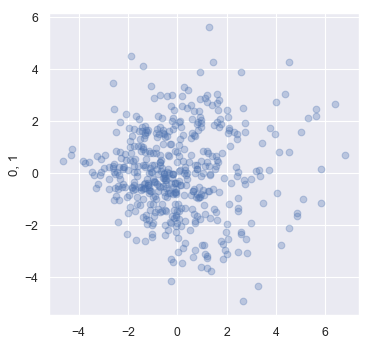

In [173]:
import seaborn as sns
sns.set()

figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(features_train[:, 0], features_train[:, 1], alpha = 0.3)
plt.ylabel('0, 1')

In [174]:
features_test.shape

(75, 71)

In [175]:
features_train.shape

(467, 71)

In [176]:
features_val.shape

(201, 71)

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


logit = LogisticRegression(solver='liblinear', max_iter=500)

best_logit = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.0001, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

penalties = ['l1', 'l2']
tols = [1e-2, 1e-3, 1e-4]
costs = [0.001, 0.01, 0.1, 1, 5, 10]
intercepts = [0.0001, 0.001, 0.1, 1]
fit_intercepts = [True, False]
classWeights = [None, 'balanced']

params_logit = {'C': costs, 'penalty': penalties, 'tol': tols, 
                'fit_intercept': fit_intercepts, 'class_weight': classWeights, 'intercept_scaling': intercepts}

gs_logit = GridSearchCV(logit, params_logit, cv=10)

best_logit.fit(features_train, target_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.0001, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Balanced_Accuracy: 0.6857892335766423
              precision    recall  f1-score   support

           0       0.82      0.72      0.76       137
           1       0.52      0.66      0.58        64

   micro avg       0.70      0.70      0.70       201
   macro avg       0.67      0.69      0.67       201
weighted avg       0.72      0.70      0.70       201



<module 'matplotlib.pyplot' from '/Users/Henry/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

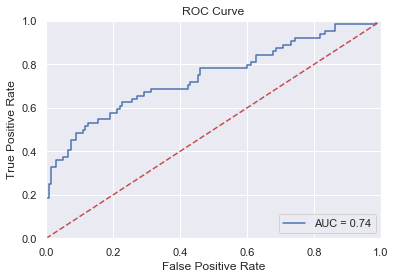

In [178]:
predictions = best_logit.predict(features_val)
getReport(predictions, 'val')
plotROC(best_logit, 'val')

Balanced_Accuracy: 0.7933130699088147
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        47
           1       0.77      0.71      0.74        28

   micro avg       0.81      0.81      0.81        75
   macro avg       0.80      0.79      0.80        75
weighted avg       0.81      0.81      0.81        75



<module 'matplotlib.pyplot' from '/Users/Henry/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

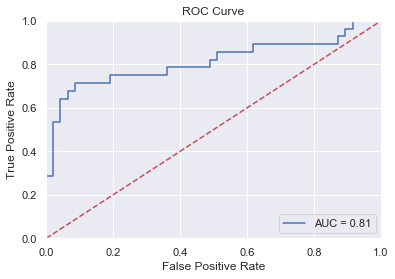

In [179]:
predictions = best_logit.predict(features_test)
getReport(predictions, 'test')
plotROC(best_logit, 'test')

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)

num_trees = [10, 15, 20, 25, 30, 40, 50]
criterion = ['gini']
max_depth = [10, 20, 30]
min_samples_leaf = [1,2,3,4]
min_samples_split = [1,2,3,4]

params_rf = {'n_estimators': num_trees, 'criterion': criterion, 'max_depth': max_depth}
gs_rf = GridSearchCV(rf, params_rf, cv=10)

gs_rf.fit(features_train, target_train)
gs_rf.best_estimator_

In [ ]:
predictions = gs_rf.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_rf, 'val')

In [ ]:
predictions = gs_rf.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_rf, 'test')